Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteDownloading https://github.com/ultralytics/assets/releases/download/v8.3.0/yolov8s.pt to 'yolov8s.pt'...


100%|██████████| 21.5M/21.5M [00:00<00:00, 159MB/s]



image 1/1 /content/gun.jpg: 224x640 1 knife, 379.9ms
Speed: 8.8ms preprocess, 379.9ms inference, 30.8ms postprocess per image at shape (1, 3, 224, 640)


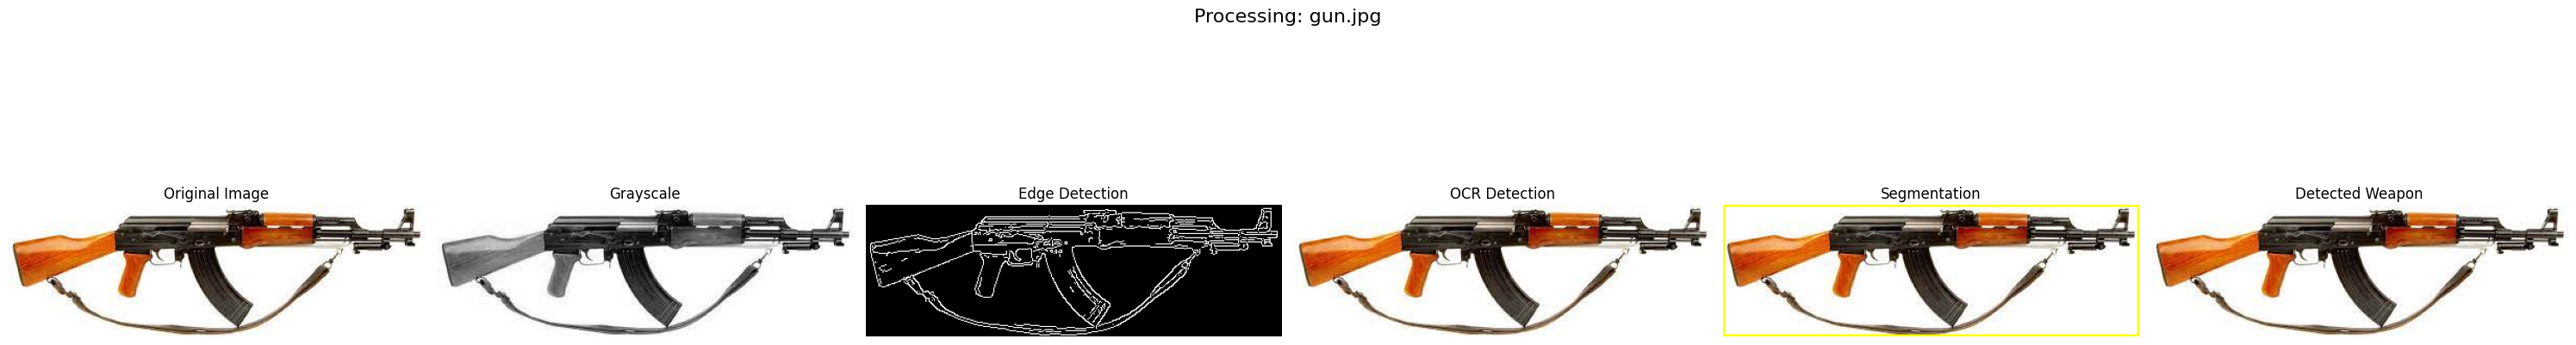


image 1/1 /content/TANK.jpg: 448x640 5 persons, 1 truck, 2 potted plants, 442.9ms
Speed: 4.3ms preprocess, 442.9ms inference, 5.9ms postprocess per image at shape (1, 3, 448, 640)


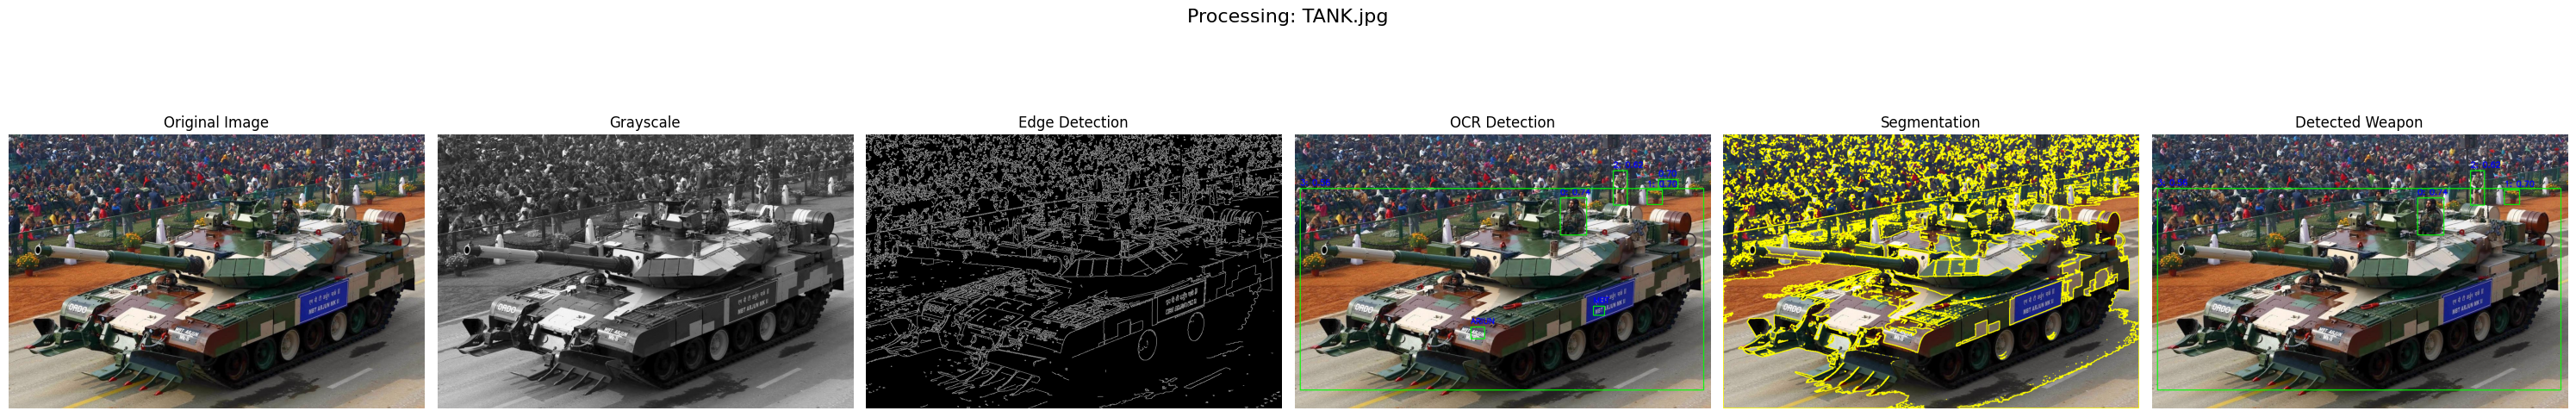


image 1/1 /content/jet.webp: 416x640 1 person, 1 airplane, 648.6ms
Speed: 4.4ms preprocess, 648.6ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 640)


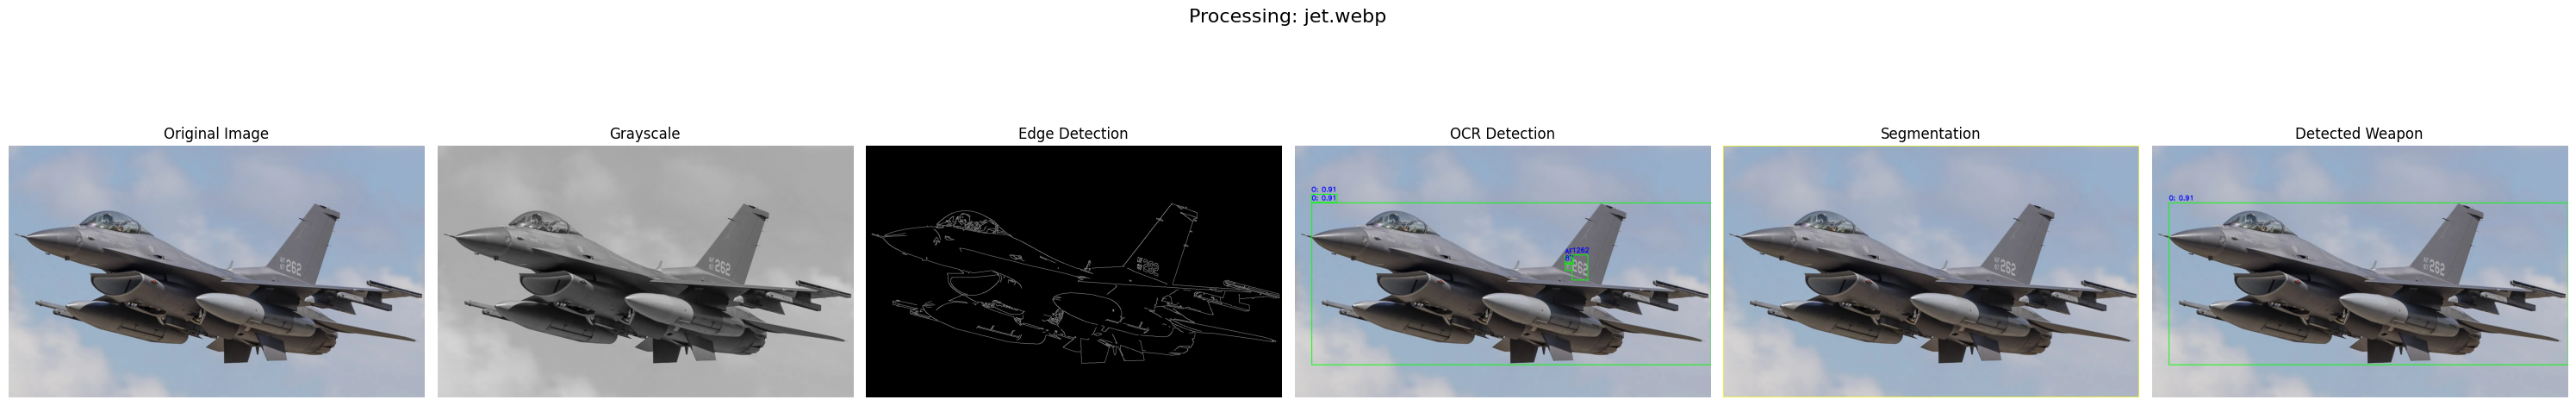


image 1/1 /content/grenade.jpg: 640x480 1 bottle, 631.4ms
Speed: 19.1ms preprocess, 631.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


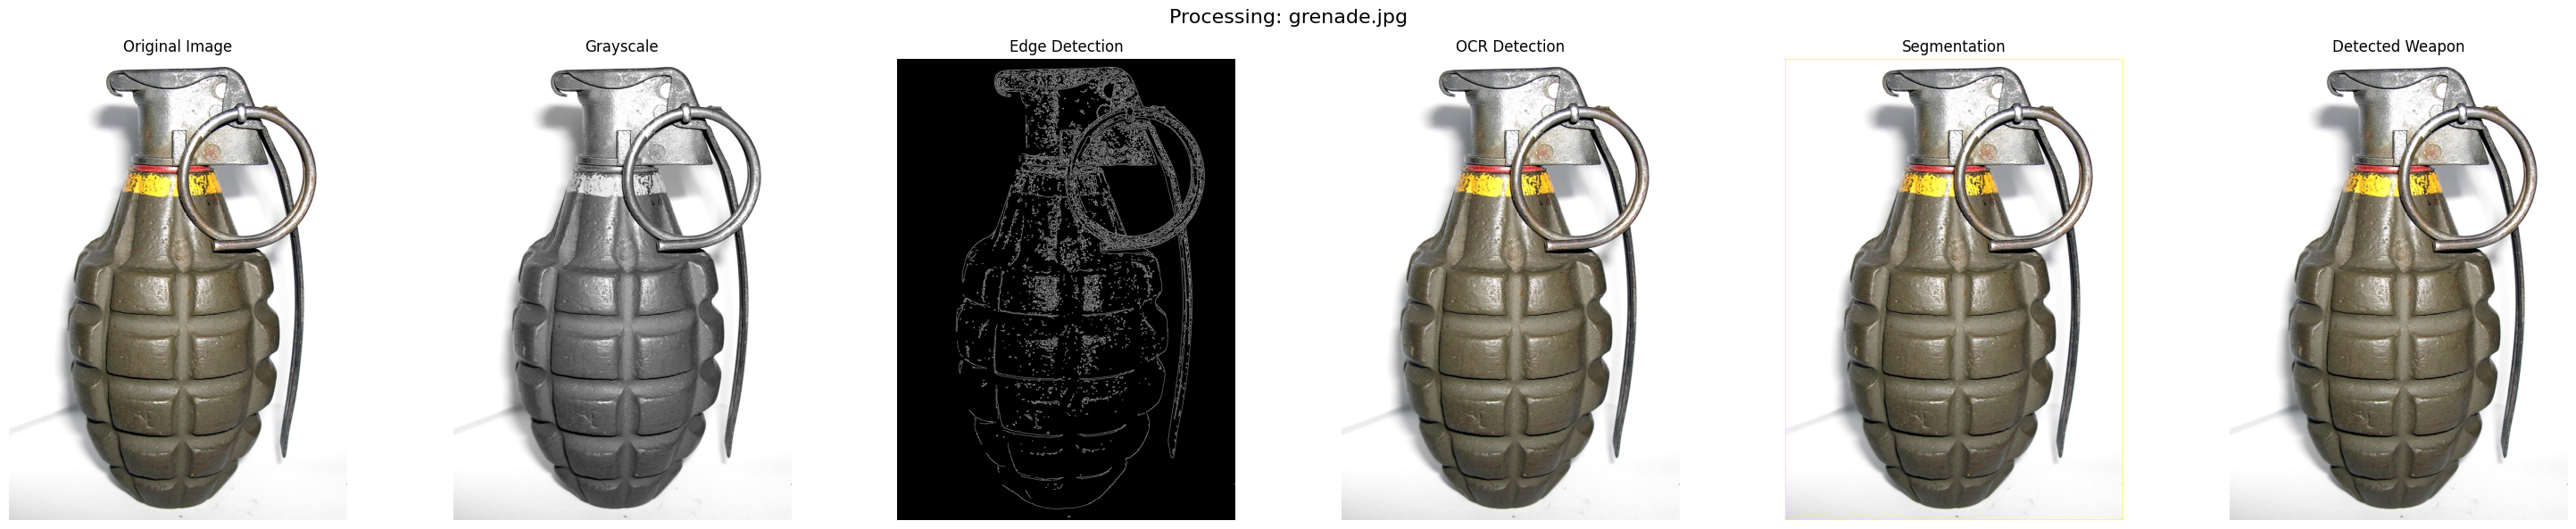


image 1/1 /content/soldier.jpg: 448x640 2 persons, 1 suitcase, 1 skis, 485.7ms
Speed: 6.4ms preprocess, 485.7ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


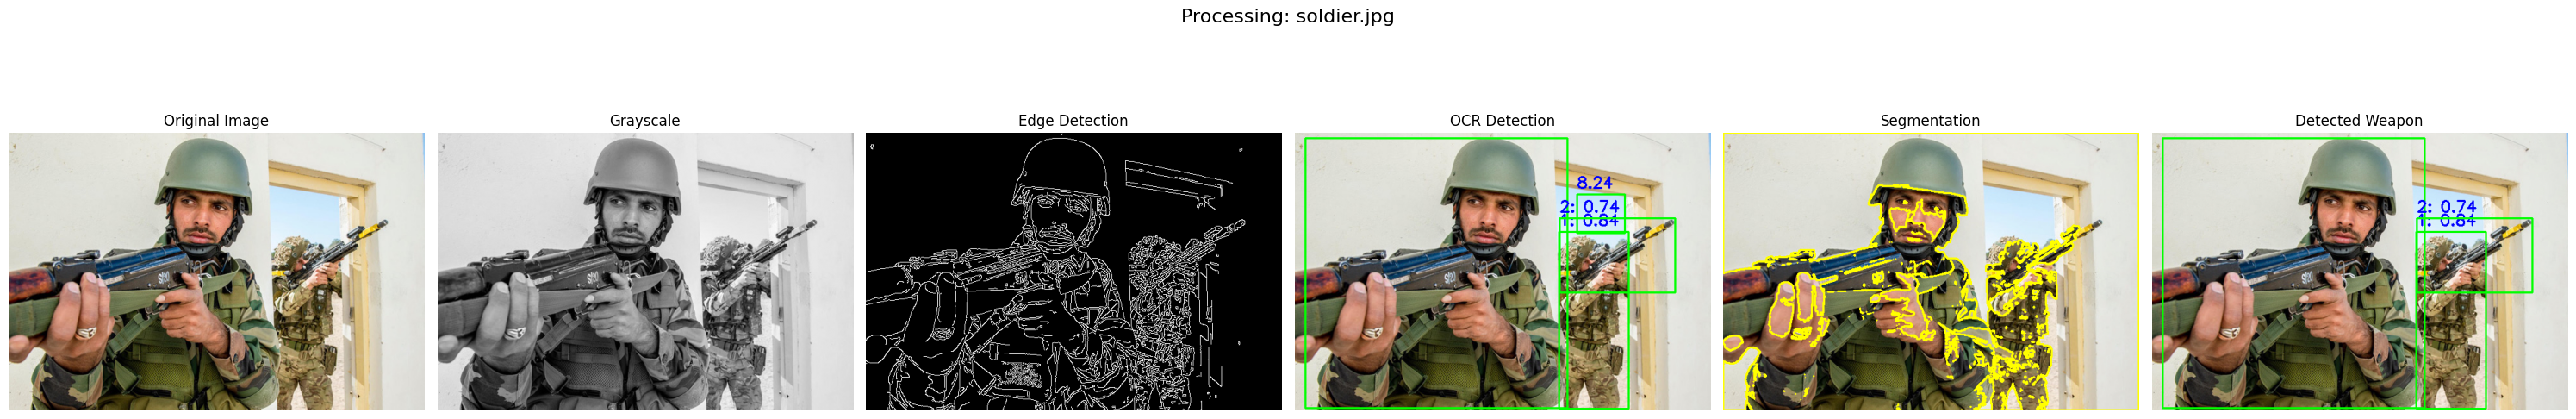


image 1/1 /content/tejas.jpg: 480x640 1 airplane, 741.6ms
Speed: 9.4ms preprocess, 741.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


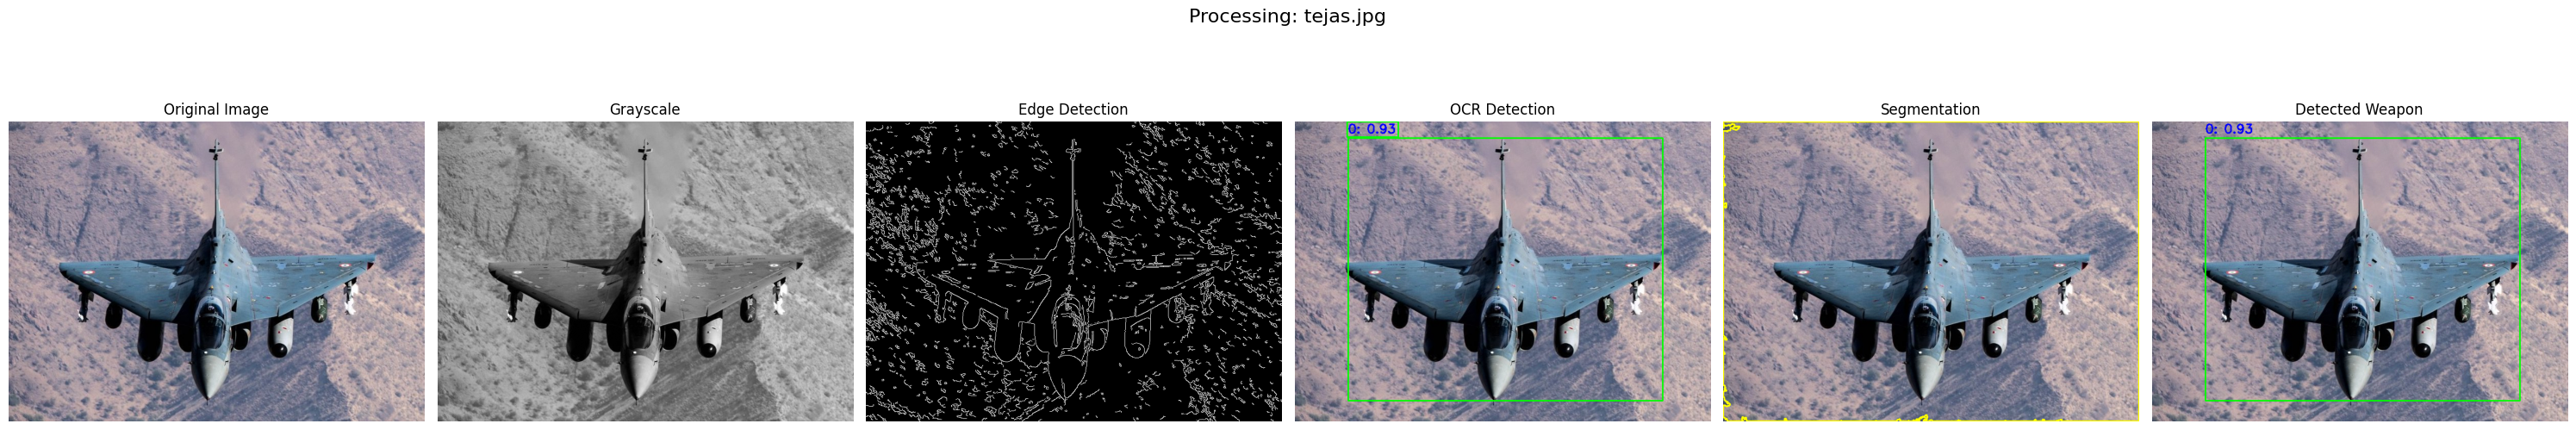

In [ ]:
import cv2
import easyocr
import numpy as np
import matplotlib.pyplot as plt
import os
import uuid
from ultralytics import YOLO

# ------------------ Configuration ------------------ #
IMAGE_PATHS = [
    'gun.jpg',
    'TANK.jpg',
    'jet.webp',
    'grenade.jpg',
    'soldier.jpg',
    'tejas.jpg'
]

# Create output directory for cropped OCR regions
CROP_OUTPUT_DIR = 'ocr_crops'
os.makedirs(CROP_OUTPUT_DIR, exist_ok=True)

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'], gpu=False)

# Load YOLOv8 pretrained model for object detection
model = YOLO("yolov8s.pt")  # Load pretrained YOLOv8 model

# ------------------ Processing Loop ------------------ #
for image_path in IMAGE_PATHS:
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    # ------------------ Load and Preprocess ------------------ #
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load: {image_path}")
        continue

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)

    # ------------------ Image Segmentation ------------------ #
    _, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented_image = image.copy()
    cv2.drawContours(segmented_image, contours, -1, (0, 255, 255), 2)
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)

    # ------------------ Weapon Detection with YOLO ------------------ #
    results = model(image_path)  # Run YOLOv8 for object detection

    # Extract bounding boxes and labels
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding box coordinates
    labels = results[0].names  # Labels of detected objects (e.g., 'gun', 'tank')
    confidences = results[0].boxes.conf.cpu().numpy()  # Confidence scores

    # Initialize flag for weapons detected
    detected_weapons = []

    # Define a set of object categories to look for
    target_labels = ['jet', 'gun', 'tank', 'grenade']

    # Loop through detections to check for the specific targets
    for box, label, confidence in zip(boxes, labels, confidences):
        if confidence > 0.5:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            # Draw the bounding box and label
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f"{label}: {confidence:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

            # Check if the label is in our target labels and print a message
            if label in target_labels and label not in detected_weapons:
                detected_weapons.append(label)
                print(f"{label.capitalize()} detected")

    # ------------------ OCR Detection & Cropping ------------------ #
    results = reader.readtext(image)
    image_with_boxes = image.copy()

    for i, (bbox, text, prob) in enumerate(results):
        if prob > 0.5:
            (top_left, _, bottom_right, _) = bbox
            top_left = tuple(map(int, top_left))
            bottom_right = tuple(map(int, bottom_right))

            # Clamp coordinates within image bounds
            x1 = max(0, top_left[0])
            y1 = max(0, top_left[1])
            x2 = min(image.shape[1], bottom_right[0])
            y2 = min(image.shape[0], bottom_right[1])

            # Draw bounding box and label
            cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image_with_boxes, text, (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

            # Crop and save region
            cropped = image[y1:y2, x1:x2]
            if cropped.size == 0:
                continue  # Skip empty crops

            safe_text = "".join(c for c in text if c.isalnum())[:10] or "text"
            crop_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}{safe_text}{uuid.uuid4().hex[:6]}.png"
            crop_path = os.path.join(CROP_OUTPUT_DIR, crop_filename)
            cv2.imwrite(crop_path, cropped)

    image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    # ------------------ Visualization ------------------ #
    fig, axs = plt.subplots(1, 6, figsize=(30, 6))
    fig.suptitle(f"Processing: {os.path.basename(image_path)}", fontsize=16)

    titles = ["Original Image", "Grayscale", "Edge Detection", "OCR Detection", "Segmentation", "Detected Weapon"]
    images = [image_rgb, gray_image, edges, image_with_boxes_rgb, segmented_image_rgb, cv2.cvtColor(image, cv2.COLOR_BGR2RGB)]
    cmaps = [None, 'gray', 'gray', None, None, None]

    for ax, img, title, cmap in zip(axs, images, titles, cmaps):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00
